In [1]:
import noise

from pdesign import canvas, shapes, lines
from pdesign import transforms as trans
from pdesign import smooth as smooth_lib


import numpy as np
from shapely.geometry import MultiLineString, LineString, Point, Polygon, MultiPoint
from shapely.geometry import box as Box
from shapely.ops import unary_union
from shapely import affinity
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from skimage.draw import line, circle_perimeter
from skimage import draw

from ipywidgets import widgets
from ipywidgets import interact, interact_manual, interactive

from matplotlib.collections import LineCollection
from matplotlib.collections import PatchCollection

from scipy.ndimage import filters
from scipy import signal
from scipy.stats import multivariate_normal

import skimage
from skimage.feature import shape_index

from skimage import draw
from sklearn import preprocessing
from scipy import interpolate

from plottermagic.io import io

from scipy.ndimage import filters
from scipy import ndimage, misc

from skimage import exposure

from skimage.transform import rescale

from skimage import io as skio


from skimage.morphology import disk
from skimage.filters import rank, unsharp_mask

from skimage.transform import pyramids
from skimage import transform

import heapq

from tqdm import notebook

In [2]:
img = io.load_image("/Users/gnb/source_photos/marie/midport_nobackround.jpg", as_type='grey').astype(float)
img = transform.rescale(img, 1/5)



#base_img = io.load_image("/Users/gnb/source_photos/geoff_japan.jpg", as_type='grey').astype(float)

img.shape

(1152, 768)

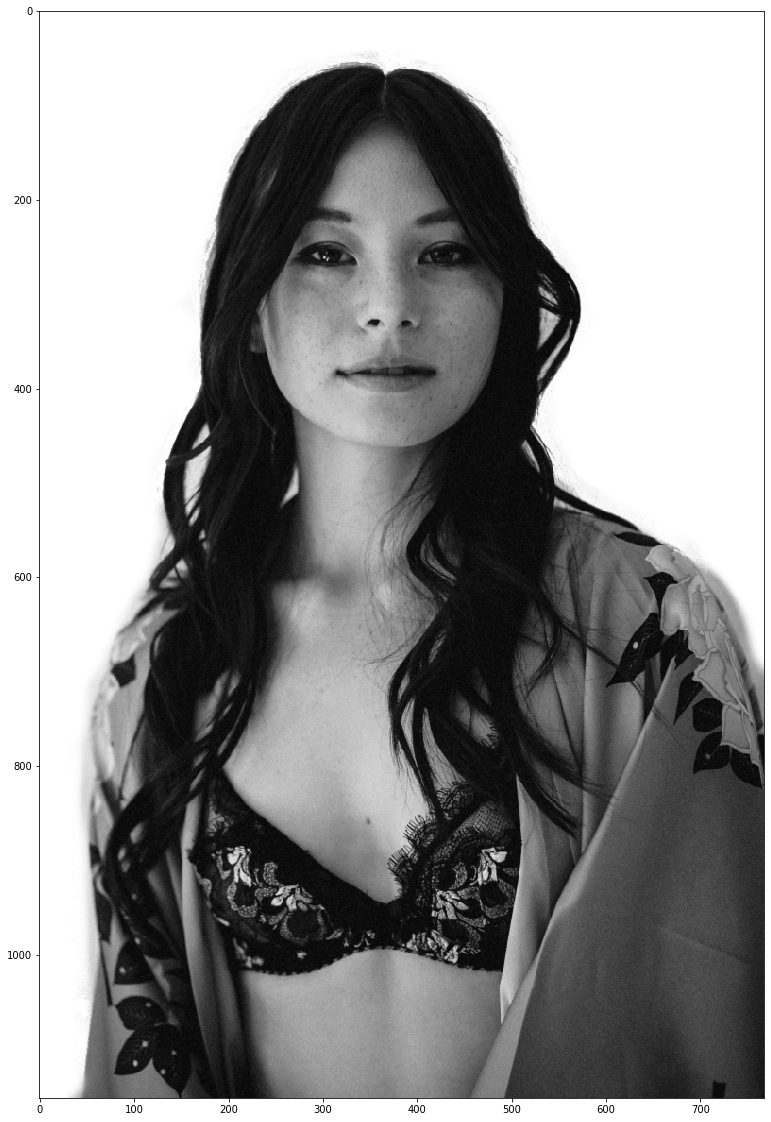

In [3]:
plt.figure(figsize=(20,20))
plt.imshow(-img, cmap='Greys')

In [4]:
img_original = img.copy()
intensity = img.copy()
has_seen = img.copy()<0



dithered = np.zeros_like(img)

threshold = 60
diffuse_radius = 0.03*img.shape[0]
k = 2

g_minus = 5
g_plus = 1

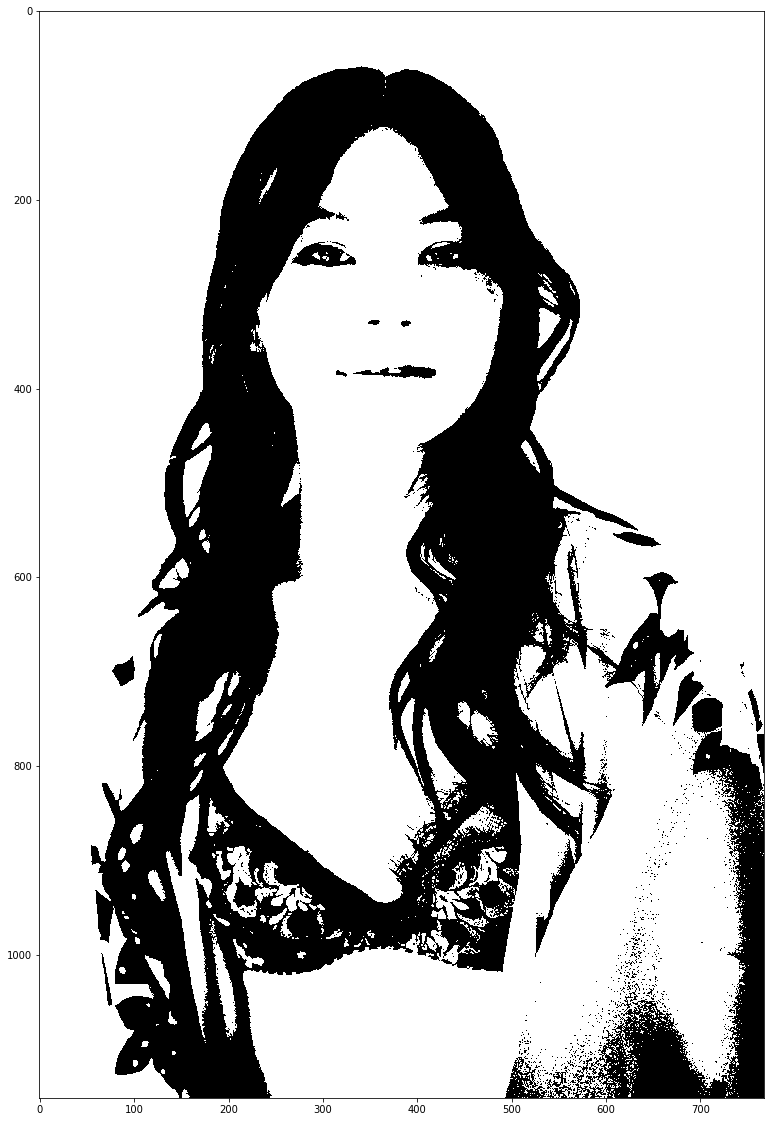

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(img<threshold, cmap='Greys')

In [6]:
xx, yy = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]), indexing='ij')

In [7]:
hp = []
ptuples = np.dstack([np.maximum(img, 255-img), xx, yy]).reshape(-1, 3)

for i, x, y in ptuples:
    heapq.heappush(hp, (i, (int(x),int(y))))


In [8]:
#r_min, r_max = 0.01, 0.25
r_min, r_max = 0.75, 1.25
stipple_size = lambda i :r_min + ((r_max-r_min)/255)*(255-i)

In [9]:
def error_diffuse(pind, err, intensity, r):
    
    cx, cy = draw.circle(*pind, diffuse_radius, shape=intensity.shape)
    cx, cy = cx[np.argwhere(~has_seen[cx, cy])].reshape(-1), cy[np.argwhere(~has_seen[cx, cy])].reshape(-1)
    
    if len(cx)>0:
    
        rmn = ((cx-pind[0])**2+(cy-pind[1])**2)**0.5

        wmn = intensity[cx, cy]
        if err<0:
            wmn = 255-wmn

        wmn = wmn/(rmn**k)
        wmn = wmn/np.maximum(np.sum(wmn), 1e-5)
        
        if err>0:
            s = r**g_plus
        else:
            s = r**-g_minus

        intensity[cx, cy] += err*wmn*s
        intensity[cx, cy] = np.clip(intensity[cx, cy], 0, 255)
        
        
        
    

In [10]:
dumb_count = 0 
stipples = []

while len(hp)>0:
    
    dumb_count+=1
    
    if dumb_count%(img.shape[0]*img.shape[1]//10)==0:
        print(dumb_count, np.mean(has_seen))
    
        
    
        
    priority, pind = heapq.heappop(hp)
    
    new_priority = np.maximum(intensity[pind], 255-intensity[pind])
    if new_priority != priority:
        heapq.heappush(hp, (new_priority, pind))
    else:
        
        r = stipple_size(intensity[pind])

        if intensity[pind]<threshold:
            app = 0
            stipples.append((pind, r))
        else:
            app = 255

        dithered[pind] = app
        has_seen[pind] = True

        err = intensity[pind]-app

        error_diffuse(pind, err, intensity, r)
    
    
    """
    if dumb_count>300000:
        break
    """
    
    

88473 0.013283058449074073
176946 0.025204128689236112
265419 0.03656457971643518
353892 0.04671450014467592
442365 0.05625293872974537
530838 0.06540708188657407
619311 0.07500768590856481
707784 0.084381103515625
796257 0.09279943395543981
884730 0.10013382523148148
973203 0.10682621708622685
1061676 0.11332307038483797
1150149 0.1191440158420139
1238622 0.12458970811631945
1327095 0.1296115451388889
1415568 0.13447288230613427
1504041 0.13921667028356483
1592514 0.14387003580729166
1680987 0.1521007396556713
1769460 0.17449159975405093
1857933 0.2043524848090278
1946406 0.23789921513310186
2034879 0.2732001410590278
2123352 0.3093849464699074
2211825 0.34639598705150465
2300298 0.38334599247685186
2388771 0.42200611255787035
2477244 0.46220341435185186
2565717 0.5030201099537037
2654190 0.5446449562355324
2742663 0.5843053747106481
2831136 0.6169704861111112
2919609 0.6820441351996528
3008082 0.78204345703125
3096555 0.8820427788628472
3185028 0.9820421006944444


In [11]:
len(stipples)

344378

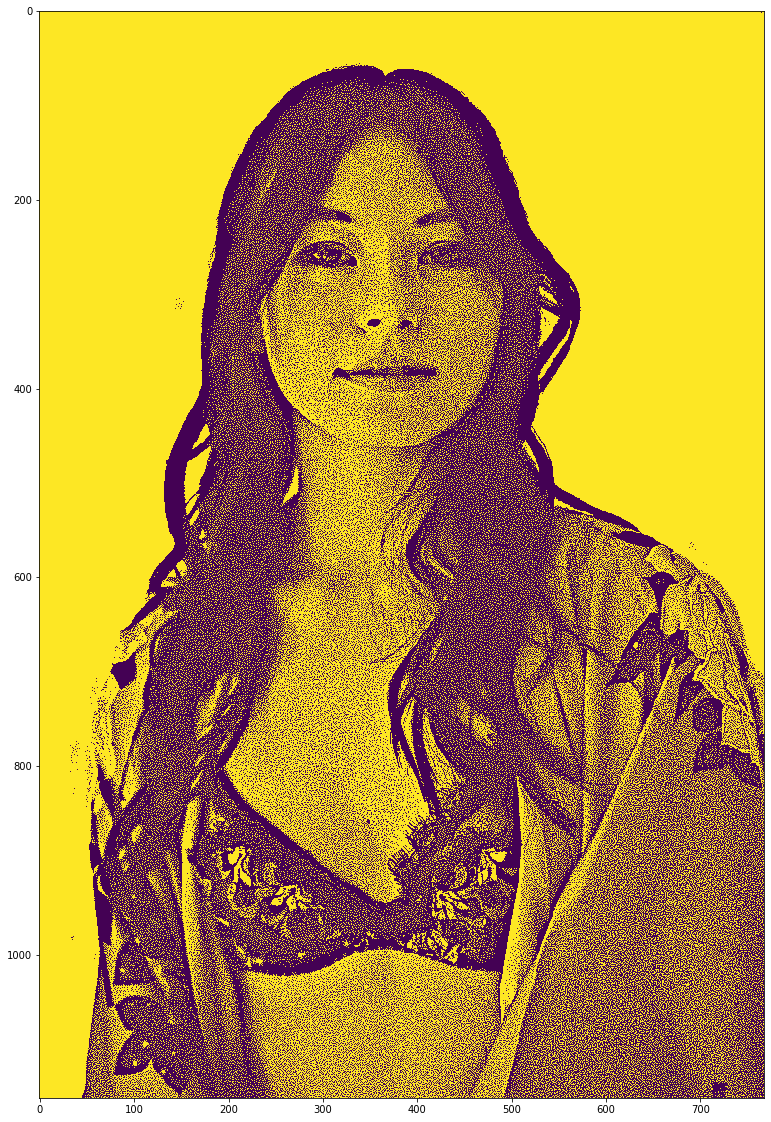

In [12]:
fig,ax = plt.subplots(figsize=(20,20))
ax.imshow(dithered)

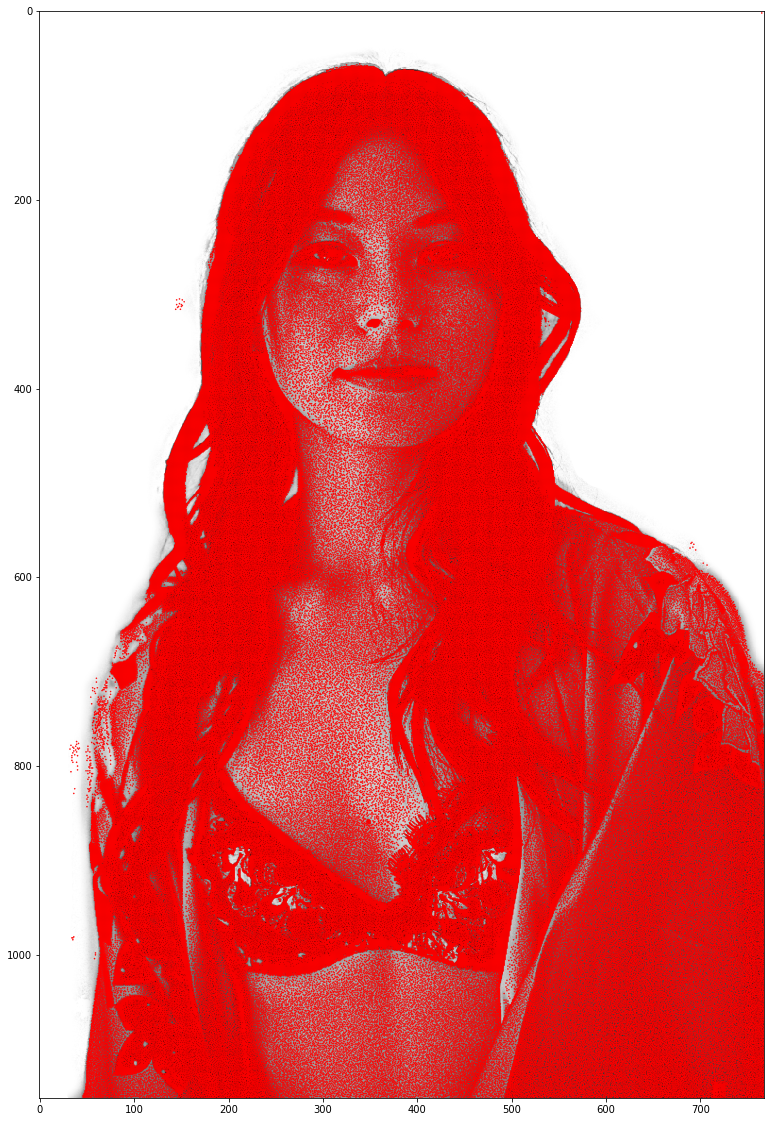

In [13]:
fig,ax = plt.subplots(figsize=(20,20))
ax.imshow(-img_original, cmap='Greys')
ax.add_collection(PatchCollection([Circle(xy[::-1], r/4) for xy, r in stipples], color='red', alpha=1))

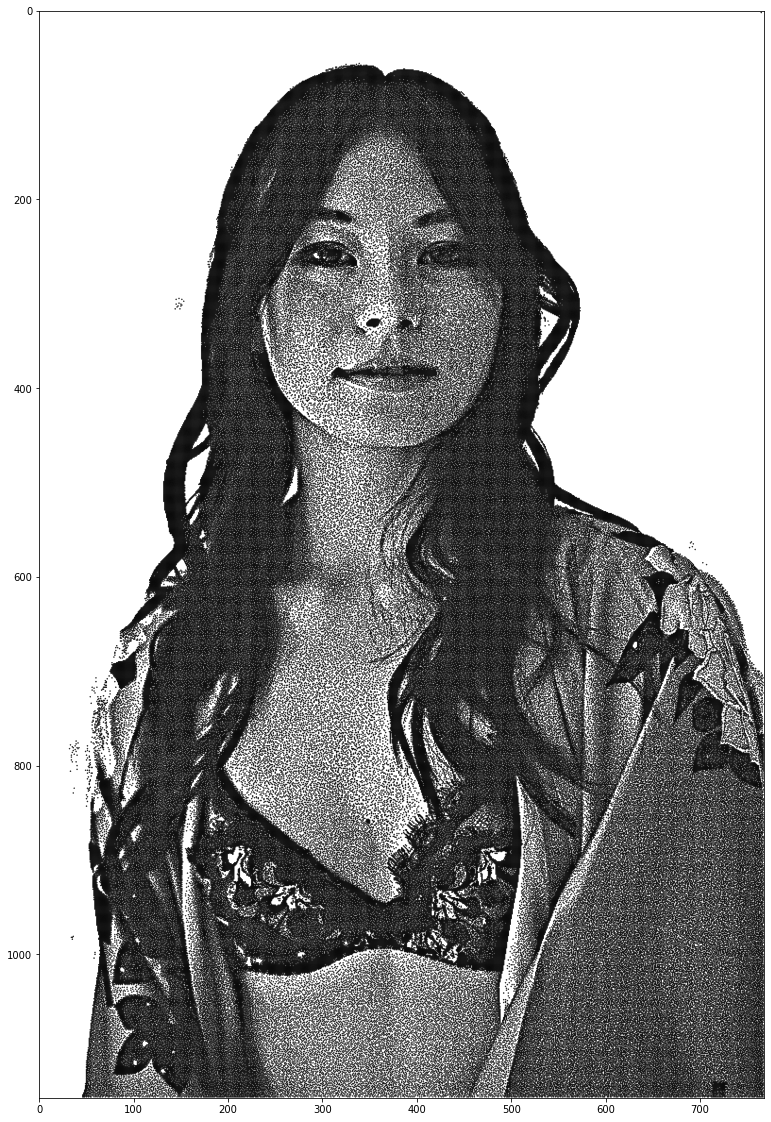

In [14]:
fig,ax = plt.subplots(figsize=(20,20))
ax.set_xlim(0, img_original.shape[1])
ax.set_ylim(img_original.shape[0], 0)
ax.add_collection(PatchCollection([Circle(xy[::-1], radius=r/5) for xy, r in stipples], color='black', alpha=1))
ax.set_aspect('equal')

In [15]:
sorted_stipples = sorted(stipples, key=lambda element: (element[0], element[1]))

In [16]:
import svgwrite
from svgwrite.shapes import Circle as svg_circle

In [17]:
rescale = img.shape[1]/9

dwg = svgwrite.Drawing(size=(11*90,14*90))
shapes = dwg.add(dwg.g(id='shapes', stroke="black", stroke_width="1", fill='none', fill_opacity='0.7'))


svg_circles = []

for xy, r in sorted_stipples:
    circ = dwg.circle(center=((str(90*(xy[1]/rescale + 1)), str(90*xy[0]/rescale))), r=0.25*0.0393701/2*90)
    shapes.add(circ)

    
save = True
if save:
    dwg.saveas("marie_stipple_svg.svg")



In [18]:
"""

rescale = img.shape[1]/9

picture = canvas.Canvas(paper_size=(11,14), margin_percent=0.05, origin='corner')
picture_bbox = Box(picture.bbox[0,0], picture.bbox[0,1], picture.bbox[1,0], picture.bbox[1,1])
dp = {
    "alpha":0.7,
    "linewidth":0.25*0.0393701*72,
    "clear":False,
}

#stips = [affinity.translate(affinity.scale(Point(xy[::-1]).buffer(r/3), 1/rescale, 1/rescale, origin=(0,0)), 1,0) for xy, r in stipples[0:15000]]
stips = [affinity.translate(affinity.scale(Point(xy[::-1]).buffer(0.25*0.0393701*72/2), 1/rescale, 1/rescale, origin=(0,0)), 1,0) for xy, r in stipples[0:15000]]

picture.make_canvas()
picture.add_grid(11,14)
picture.plot_shapes(stips, **dp)
picture.fig

save = False

picture.make_canvas()
picture.plot_shapes(stips, **dp)
picture.display_overlays(False)
if save:
    picture.fig.savefig("marie_stipple_test.svg")
picture.fig
"""

'\n\nrescale = img.shape[1]/9\n\npicture = canvas.Canvas(paper_size=(11,14), margin_percent=0.05, origin=\'corner\')\npicture_bbox = Box(picture.bbox[0,0], picture.bbox[0,1], picture.bbox[1,0], picture.bbox[1,1])\ndp = {\n    "alpha":0.7,\n    "linewidth":0.25*0.0393701*72,\n    "clear":False,\n}\n\n#stips = [affinity.translate(affinity.scale(Point(xy[::-1]).buffer(r/3), 1/rescale, 1/rescale, origin=(0,0)), 1,0) for xy, r in stipples[0:15000]]\nstips = [affinity.translate(affinity.scale(Point(xy[::-1]).buffer(0.25*0.0393701*72/2), 1/rescale, 1/rescale, origin=(0,0)), 1,0) for xy, r in stipples[0:15000]]\n\npicture.make_canvas()\npicture.add_grid(11,14)\npicture.plot_shapes(stips, **dp)\npicture.fig\n\nsave = False\n\npicture.make_canvas()\npicture.plot_shapes(stips, **dp)\npicture.display_overlays(False)\nif save:\n    picture.fig.savefig("marie_stipple_test.svg")\npicture.fig\n'

In [19]:
"""
#stips = [affinity.translate(affinity.scale(Point(xy[::-1]).buffer(r/3), 1/rescale, 1/rescale, origin=(0,0)), 1,0) for xy, r in stipples[0:15000]]
#stips = [affinity.translate(affinity.scale(Point(xy[::-1]).buffer(0.25*0.0393701*72/2), 1/rescale, 1/rescale, origin=(0,0)), 1,0) for xy, r in stipples]
stips = [Point(11 - (xy[1]/rescale + 1), xy[0]/rescale).buffer(0.25*0.0393701/2) for xy,r in stipples]


picture.make_canvas()
picture.add_grid(11,14)
picture.plot_shapes(stips, **dp)
picture.fig

save = True



picture.make_canvas()
picture.plot_shapes(stips, **dp)
picture.display_overlays(False)
if save:
    picture.fig.savefig("marie_stipple_full.svg")
picture.fig




mpl_circles = [Circle((11 - (xy[1]/rescale + 1), xy[0]/rescale), 0.25*0.0393701/2) for xy,r in stipples]
picture.make_canvas()
picture.add_grid(11,14)
picture.ax.add_collection(PatchCollection(mpl_circles))
picture.fig


save = False

picture.make_canvas()
picture.ax.add_collection(PatchCollection(mpl_circles))
picture.display_overlays(False)
if save:
    picture.fig.savefig("marie_stipple_full.svg")
picture.fig
"""

'\n#stips = [affinity.translate(affinity.scale(Point(xy[::-1]).buffer(r/3), 1/rescale, 1/rescale, origin=(0,0)), 1,0) for xy, r in stipples[0:15000]]\n#stips = [affinity.translate(affinity.scale(Point(xy[::-1]).buffer(0.25*0.0393701*72/2), 1/rescale, 1/rescale, origin=(0,0)), 1,0) for xy, r in stipples]\nstips = [Point(11 - (xy[1]/rescale + 1), xy[0]/rescale).buffer(0.25*0.0393701/2) for xy,r in stipples]\n\n\npicture.make_canvas()\npicture.add_grid(11,14)\npicture.plot_shapes(stips, **dp)\npicture.fig\n\nsave = True\n\n\n\npicture.make_canvas()\npicture.plot_shapes(stips, **dp)\npicture.display_overlays(False)\nif save:\n    picture.fig.savefig("marie_stipple_full.svg")\npicture.fig\n\n\n\n\nmpl_circles = [Circle((11 - (xy[1]/rescale + 1), xy[0]/rescale), 0.25*0.0393701/2) for xy,r in stipples]\npicture.make_canvas()\npicture.add_grid(11,14)\npicture.ax.add_collection(PatchCollection(mpl_circles))\npicture.fig\n\n\nsave = False\n\npicture.make_canvas()\npicture.ax.add_collection(Patch

In [4]:
from pyaxidraw import axidraw   
ad = axidraw.AxiDraw()
ad.interactive()
ad.connect()


ad.options.model = 2
ad.options.pen_pos_up = 50
ad.options.pen_pos_down = 43
ad.update()


ad.plot_setup("marie_stipple_svg.svg")
ad.plot_run()

Plot paused by button press.
Use the resume feature to continue.


In [7]:
ad.options.mode = "res_plot"
ad.options.pen_pos_up = 50
ad.options.pen_pos_down = 43
ad.update()

ad.plot_run()

Failed after command: SC,4,18843
Failed after command: SC,5,17585
Failed after command: SC,11,1350
Failed after command: SC,12,900
Failed after command: EM,1,1
